## Module 4: Epidemiological Models

## Team Members:
Wyatt Young and Aarnav Shah

## Project Title:
Predicting the Mexican 2009 H1N1 Outbreak

## Project Goal:
This project seeks to numerically solve the ordinary differential equation to predict the progression of Mexico's 2009 Swine Flu Outbreak based on initial data of virus spreading.

## Disease Background:

* Prevalence & incidence
    * Through 2009 and 2010, the estimated number of global cases of swine flu vary from 43 to 89 million. Mexico reported a total of 27,500 of these cases, but since these only include lab-confirmed cases, it's likely an underestimate. Another source (Vargas-Parada) reports 66,000 infections. 
    * Given the population of Mexico was 112 million, this gives us an incidence rate between 2.5 - 6 cases per 10,000 cases through the pandemic. However, it might be a stretch to include the entire Mexican population in this calculation, since the CDC reports that a portion of the older population (>65 years) might have had H1N1 antibodies from previous exposure to the virus. If that were taken into account, the incidence rate would be slightly higher. 
* Economic burden
    * Since this was a pandemic, the economic impacts stretch beyond just healthcare costs. Swine flu also spread through pigs, or swine, and this negatively impacted Mexico's pork exports. Their tourism industry also took a massive hit. The pandemic also occurred shortly after the global financial crisis of 2008, which amplified the negative outcomes of the recession. 
    * Healthcare related costs involve subsidising health insurance and health costs, and emergency health responses.
    * The total economic cost was estimated to be 2.2 billion USD, reported by the Mexican government. 
* Risk factors (genetic, lifestyle) & Societal determinants
    * Exposure to pigs is the biggest risk factor for H1N1, so it affected professions like farming and meat processing the most. 
    * People with a weakened immune system and other conditions like asthma or diabetes were also at higher risk.
        * Very young children and the elderly were at higher risk due to their weaker immune systems.
* Symptoms
    * Quick adoption of a myriad of symptoms including, cough, fever, muscle aches, sore throat, chills, eye pain, body aches, headaches, tiredness, and general malaise. In severe cases, pneumonia, hemorrhagic bronchitis, respiratory failure, and even death.
* Diagnosis
    * Typically a physical exam by a health care provider, in person or over the phone, can determine if a patient has the swine flu. Several forms of testing including rapid antigen test or a RT-PCR can confirm a case of swine flu.
* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology)
    * Swine flu is transmitted in the air that gets inhaled by the susceptible individual. H1N1 affects the upper and lower respiratory tracts where it is engulfed into the host’s cells. Here it can use the host’s resources to replicate its own DNA and proliferate. This is how the disease is spread. In severe cases, the respiratory tract develops to a pneumonia like state and inflammation can cause desquamative bronchiolitis. Ultimately, the virus causes necrosis which allows it to infiltrate the lungs and affected respiratory areas.

sources:
https://www.mayoclinic.org/diseases-conditions/swine-flu/symptoms-causes/syc-20378103, 
https://www.mayoclinic.org/diseases-conditions/swine-flu/diagnosis-treatment/drc-20378106, 
https://www.ncbi.nlm.nih.gov/books/NBK513241/, 
https://www.npr.org/sections/health-shots/2009/05/swine_flu_hits_mexico_economy.html, 
https://archive.cdc.gov/www_cdc_gov/flu/pandemic-resources/2009-h1n1-pandemic.html 

## Dataset: 

We're using time series data of the Mexican Swine Flu outbreak in 2009, which simply contains data about the date and cumulative reported cases of H1N1 in Mexico in 2009. It is likely that these figures are underreporting true infection count, as elaborated on under the prevalence & incidence section above. The data set spans from April 24th to July 6th 2009, and uses data reported by the country of Mexico to the World Health Organization. The data comes from Kaggle.com and claims to report daily confirmed cases counts; however, there are several missing days during this period and several repeated confirmed cases numbers for a series of 2-3 days. The data set appears to be relatively reliable as it is from the WHO, but the missing days and other underreporting concerns should cause skepticism when looking at the data set. 

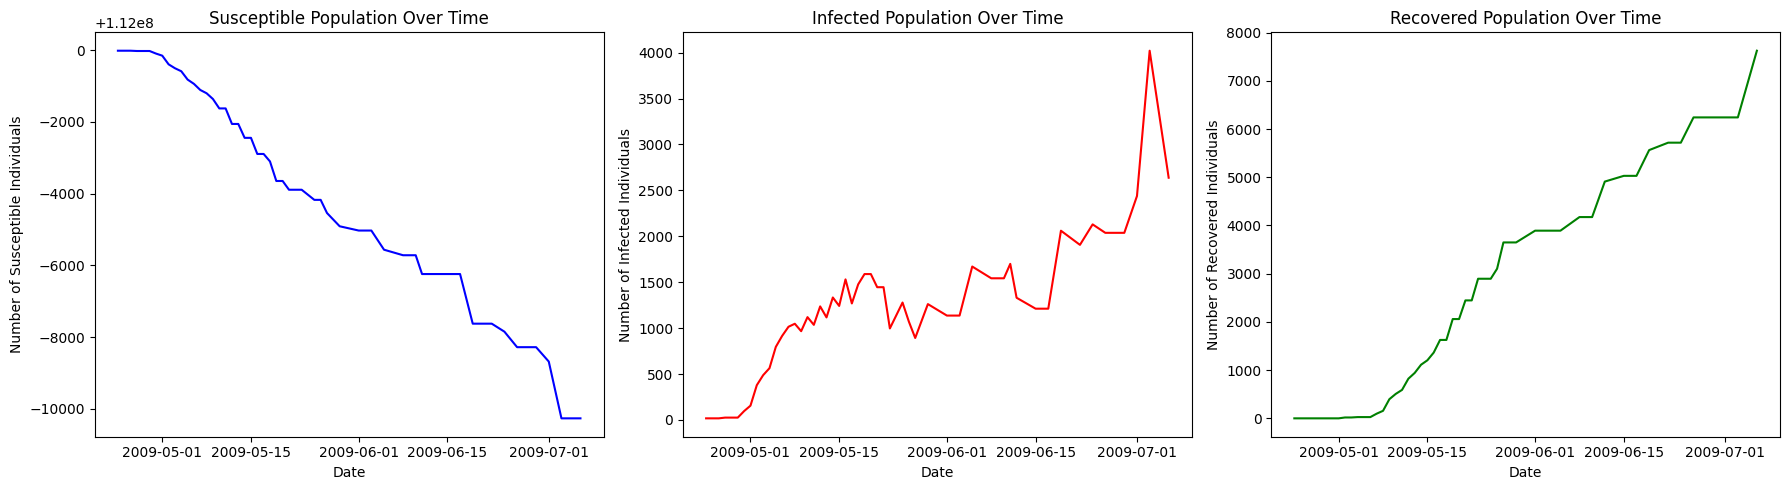

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from main_functions import convert_cumulative_to_SIR
import numpy as np

# 1. Read in the csv file of cumulative cases.
df = pd.read_csv('swine_flu_mexico_data_2009_cumulative.csv')

# Renaming the column for to work with the convert_cumulative_to_SIR function
df = df.rename(columns={'confirmed_cases': 'cumulative_cases'})

# 2. Use the convert_cumulative_to_SIR function to convert cumulative cases to approximate S, I, R at any given time.
SIR_df = convert_cumulative_to_SIR(df, population=112000000, infectious_period=7)

# 3. Plot S, I, R over time.
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(SIR_df['date'], SIR_df['S_est'], color='blue')
ax[0].set_title('Susceptible Population Over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Susceptible Individuals')

ax[1].plot(SIR_df['date'], SIR_df['I_est'], color='red')
ax[1].set_title('Infected Population Over Time')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Infected Individuals')

ax[2].plot(SIR_df['date'], SIR_df['R_est'], color='green')
ax[2].set_title('Recovered Population Over Time')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Number of Recovered Individuals')

plt.tight_layout()
plt.show()

In [3]:
# Fill in empty days
date_range = pd.date_range(start=SIR_df['date'].min(), end=SIR_df['date'].max())
SIR_df = SIR_df.set_index('date').reindex(date_range).interpolate().reset_index()
SIR_df = SIR_df.rename(columns={'index': 'date'})
SIR_df['date'] = pd.to_datetime(SIR_df['date'])

# Take means based on surrounding values on empty days - if the next value is Nan, it just takes the previous value

for index, row in SIR_df.iterrows():
    if pd.isna(row['cumulative_cases']):
        prev = SIR_df.iloc[int(index)-1]["cumulative_cases"]
        next = SIR_df.iloc[int(index)+1]["cumulative_cases"]
        print(prev, next)
        if pd.isna(next) or prev >= next:
            SIR_df.at[index, 'cumulative_cases'] = prev
        else:
            SIR_df.at[index, 'cumulative_cases'] = (prev + next) / 2

## Data Analyis: 

### Methods

We tried to model the spread of the H1N1 outbreak in Mexico using an SIR model, which is a simple system of ODEs that tracks the susceptible, infected, and recovered populations. This method is commonly used in epidemiology and can often create accurate models with strong predicting power. The model relies on two constants, beta and gamma, which represent how contagious the virus is and the time taken to recover from it respectively. 

In order to fit the model, we tried both the ODE to the whole dataset and fitting it to only the first half of the dataset, which let us evaluate it in comparison to the actual data. Similarly, we used two numerical methods of solving the ODE: euler's method, which is a simple approximation made by adding the gradient * step size, and a 4th order Runge-Kutte method. 

Because the dataset was incomplete, we interpolated numbers for missing days in the cell above.

### Analysis


#### 1. Fitting the SIR Model

In [4]:
# Using the euler_SIR function defined earlier, we can simulate the SIR model over time.

from main_functions import euler_sir

I_obs = SIR_df['I_est'].astype(float)

t_obs = np.arange(0, len(I_obs), 1)

N = 112000000

I0_obs = I_obs[0]
R0_obs = 0.0
S0_obs = N - I0_obs - R0_obs


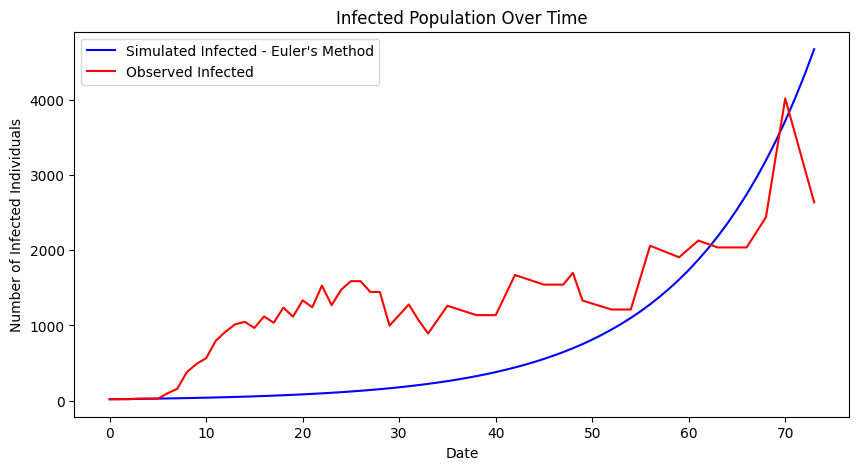

In [5]:
# Plug in guesses for gamma and beta, plot the model predictions against the data, and calculate SSE.

beta = 0.222
gamma = 1/7

S, I, R = euler_sir(beta, gamma, S0_obs, I0_obs, R0_obs, t_obs, N)

plt.figure(figsize=(10, 5))

plt.plot(t_obs, I, label='Simulated Infected', color='blue')

plt.plot(t_obs, SIR_df['I_est'], color='red')

plt.title('Infected Population Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Infected Individuals')

plt.legend(['Simulated Infected - Euler\'s Method', 'Observed Infected'])

plt.show()

In [6]:
# Use an optimization routine to minimize SSE and find the best-fitting parameters.

beta = 0.23
gamma = 1/7

# This algorithm uses gradient descent to optimize beta.
step_size = 0.01
for i in range(100):
    beta_plus = beta + step_size
    beta_minus = beta - step_size
    
    gamma_minus = gamma - step_size/10
    gamma_plus = gamma + step_size/10


    S_b_plus_g_minus, I_b_plus_g_minus, R_b_plus_g_minus = euler_sir(beta_plus, gamma_minus, S0_obs, I0_obs, R0_obs, t_obs, N)
    S_b_plus_g_plus, I_b_plus_g_plus, R_b_plus_g_plus = euler_sir(beta_plus, gamma_plus, S0_obs, I0_obs, R0_obs, t_obs, N)
    S_b_minus_g_minus, I_b_minus_g_minus, R_b_minus_g_minus = euler_sir(beta_minus, gamma_minus, S0_obs, I0_obs, R0_obs, t_obs, N)
    S_b_minus_g_plus, I_b_minus_g_plus, R_b_minus_g_plus = euler_sir(beta_minus, gamma_plus, S0_obs, I0_obs, R0_obs, t_obs, N)
    
    table = np.array([
        ["Beta Plus, Gamma Minus", np.sum((I_b_plus_g_minus - I_obs)**2)],
        ["Beta Plus, Gamma Plus", np.sum((I_b_plus_g_plus - I_obs)**2)],
        ["Beta Minus, Gamma Minus", np.sum((I_b_minus_g_minus - I_obs)**2)],
        ["Beta Minus, Gamma Plus", np.sum((I_b_minus_g_plus - I_obs)**2)]
    ])
    
    min_error = min(table[:,1])
    min_index = table[:,1].tolist().index(min_error)
    
    if min_index == 0:
        beta = beta_plus
        gamma = gamma_minus
    elif min_index == 1:
        beta = beta_plus
        gamma = gamma_plus
    elif min_index == 2:
        beta = beta_minus
        gamma = gamma_minus
    elif min_index == 3:
        beta = beta_minus
        gamma = gamma_plus
    
    # Decreasing the step size for the next iteration
    step_size *= 0.95

print("Optimized beta:", beta)


Optimized beta: 0.2331953434398958


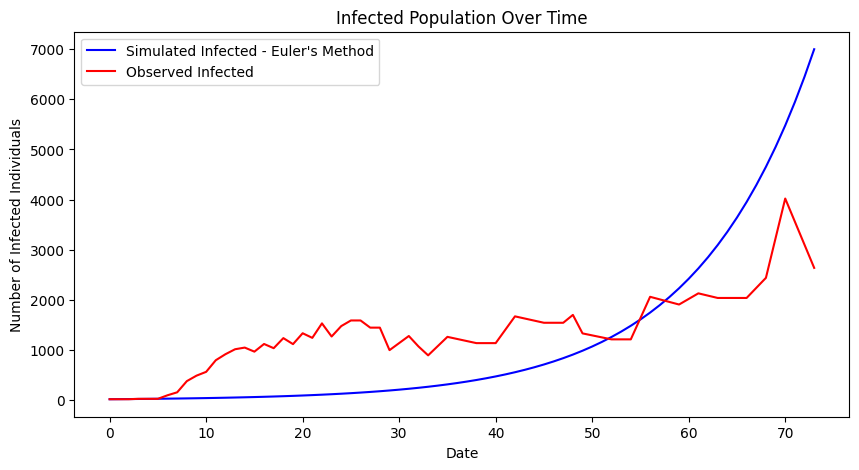

In [7]:
# Plot with the optimized beta and gamma values.

S, I, R = euler_sir(beta, gamma, S0_obs, I0_obs, R0_obs, t_obs, N)

plt.figure(figsize=(10, 5))

plt.plot(t_obs, I, label='Simulated Infected', color='blue')

plt.plot(t_obs, SIR_df['I_est'], color='red')

plt.title('Infected Population Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Infected Individuals')

plt.legend(['Simulated Infected - Euler\'s Method', 'Observed Infected'])

plt.show()


In [8]:
from scipy.optimize import minimize

def sse(params):
    beta, gamma = params
    S, I, R = euler_sir(beta, gamma, S0_obs, I0_obs, R0_obs, t_obs, N)
    return np.sum((I - I_obs)**2)

result = minimize(sse, x0=[0.3, 1/7], method="Nelder-Mead")
beta_opt, gamma_opt = result.x

print("Optimized beta (scipy):", beta_opt)
print("Optimized gamma (scipy):", gamma_opt)


Optimized beta (scipy): 14.102604680461265
Optimized gamma (scipy): 14.00591822404807


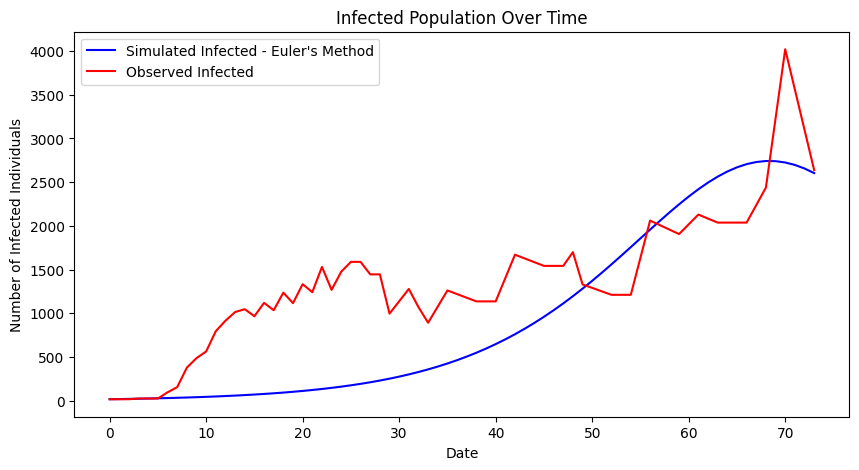

In [9]:
# Plot with the optimized beta and gamma values.

S, I, R = euler_sir(beta_opt, gamma_opt, S0_obs, I0_obs, R0_obs, t_obs, N)

plt.figure(figsize=(10, 5))

plt.plot(t_obs, I, label='Simulated Infected', color='blue')

plt.plot(t_obs, SIR_df['I_est'], color='red')

plt.title('Infected Population Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Infected Individuals')

plt.legend(['Simulated Infected - Euler\'s Method', 'Observed Infected'])

plt.show()


#### 2. Predict "the future" with your fit SIR model

Optimized beta (scipy): 46.19884720636088
Optimized gamma (scipy): 45.95413649932567


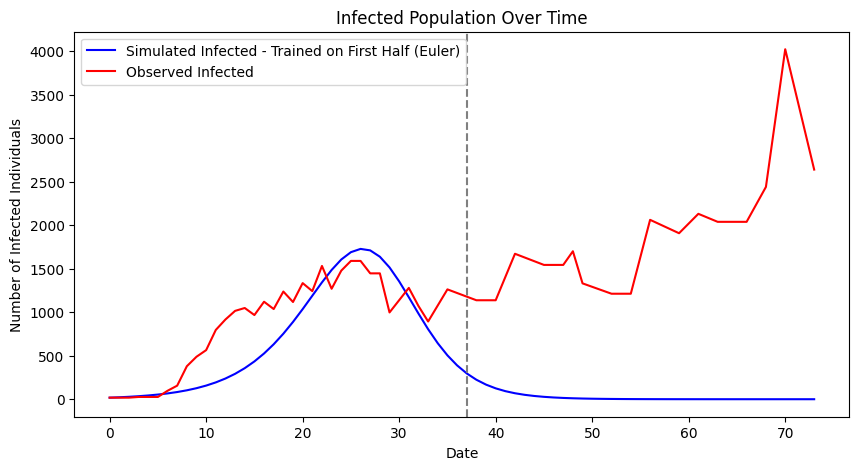

In [10]:
# Use euler's method and your optimization routine above to find new gamma and beta on the  
# FIRST HALF of the data, then simulate the SIR model forward in time using those parameters and plot.

SIR_df_half = SIR_df.iloc[:len(SIR_df)//2]

I_obs = SIR_df_half['I_est'].astype(float)

# The value of t_obs shouldn't be updated here since we're still using the full time range for simulation.
t_obs_train = np.arange(0, len(I_obs), 1)

I0_obs = I_obs[0]
R0_obs = 0.0
S0_obs = N - I0_obs - R0_obs

beta = 0.22
gamma = 1/7

def sse_2(params):
    beta, gamma = params
    S, I, R = euler_sir(beta, gamma, S0_obs, I0_obs, R0_obs, t_obs_train, N)
    return np.sum((I - I_obs)**2)

result = minimize(sse_2, x0=[0.3, 1/7], method="Nelder-Mead")
beta_opt, gamma_opt = result.x

print("Optimized beta (scipy):", beta_opt)
print("Optimized gamma (scipy):", gamma_opt)

# Plot with the optimized beta and gamma values.
S, I, R = euler_sir(beta_opt, gamma_opt, S0_obs, I0_obs, R0_obs, t_obs, N)

plt.figure(figsize=(10, 5))

plt.plot(t_obs, I, label='Simulated Infected', color='blue')
plt.plot(t_obs, SIR_df['I_est'], label='Observed Infected', color='red')

# make a line to indicate the point where training data ends and testing data begins
plt.axvline(x=len(SIR_df_half), color='gray', linestyle='--')

plt.title('Infected Population Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Infected Individuals')

plt.legend(['Simulated Infected - Trained on First Half (Euler)', 'Observed Infected'])

plt.show()

**Is the new gamma and beta close to what you found on the full dataset? Is the fit much worse? What is the SSE calculated for the second half of the data?**

The new gamma and beta values are extremely unrealistic, as a gamma value this high has never been observed, and the gamma value of ~46 suggests the infection lasts 30 minutes. These values are a lot higher than those for the first model, because the model is interpreting the slight downtick in cases to be an indication that its past the peak. The poor fit leads to a high SSE value - 146686116.35697162

In [11]:
# Calculating SSE between model predictions and data on the SECOND HALF of the data.

SIR_df_half2 = SIR_df.iloc[len(SIR_df)//2:]
I_obs = SIR_df_half2['I_est'].astype(float)

I_pred = I[len(I)//2:]

sse_second_half_euler = np.sum((I_pred - I_obs)**2)
print("SSE on the second half of the data (Euler):", sse_second_half_euler)

SSE on the second half of the data (Euler): 146686116.35697162



<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Key Point:</b> 

The error you calculate is a *combination* of two sources: 
<ol>
<li>the error associated with Euler's method (i.e. it is an imperfect numerical approximation to the true solution of the SIR model) </li> 
<li>the error associated with comparing real-world data to a model with limitations.</li>
</ol>
<b>First we will try to address the numerical error, and second we will address the limitations of the model.</b>

</div>



**Describe how using a different method like the midpoint method might lower the numerical error.**

Euler's method does not account for a function's changing slope through the step size, since it only considers the slope at the beginning of the step. Other methods like the midpoint method could more accurately capture the behavior of the curve which could lead to a better fit and reduced error. 

#### 3. Decreasing numerical error with the RK4 Method

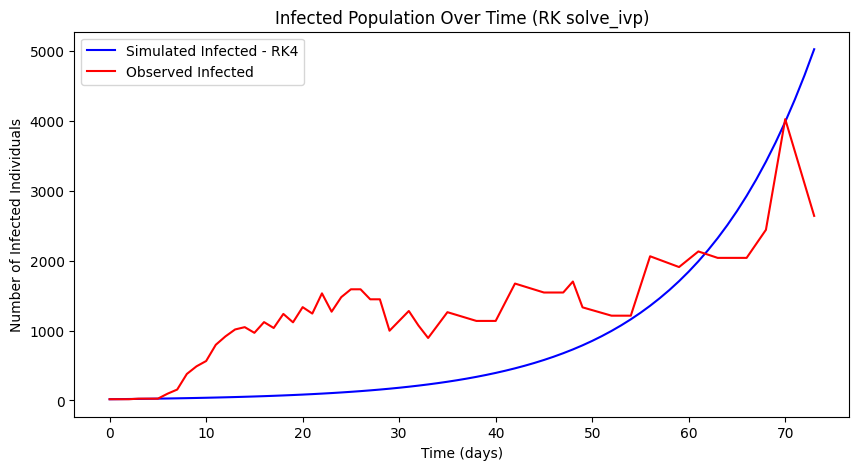

In [12]:
# Using scipy's solve_ivp function with the runge-kutta solver, re-implement the SIR model simulation, find optimal gamma and beta again, and plot the results.

from scipy.integrate import solve_ivp

def fun(t, y, beta, gamma, N):
    S, I, R = y

    dSdt = -beta / N * I * S
    dIdt = beta / N * I * S - gamma * I
    dRdt = gamma * I

    return [dSdt, dIdt, dRdt]

sol = solve_ivp(fun,
                t_span=[t_obs[0], t_obs[-1]],
                y0=[S0_obs, I0_obs, R0_obs],
                args=(beta, gamma, N),
                t_eval=t_obs,
                method='RK45') 

S_sol, I_sol, R_sol = sol.y

plt.figure(figsize=(10, 5))
plt.plot(t_obs, I_sol, label="Simulated Infected - RK4", color='blue')
plt.plot(t_obs, SIR_df['I_est'], label='Observed Infected', color='red')
plt.title('Infected Population Over Time (RK solve_ivp)')
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected Individuals')
plt.legend()
plt.show()

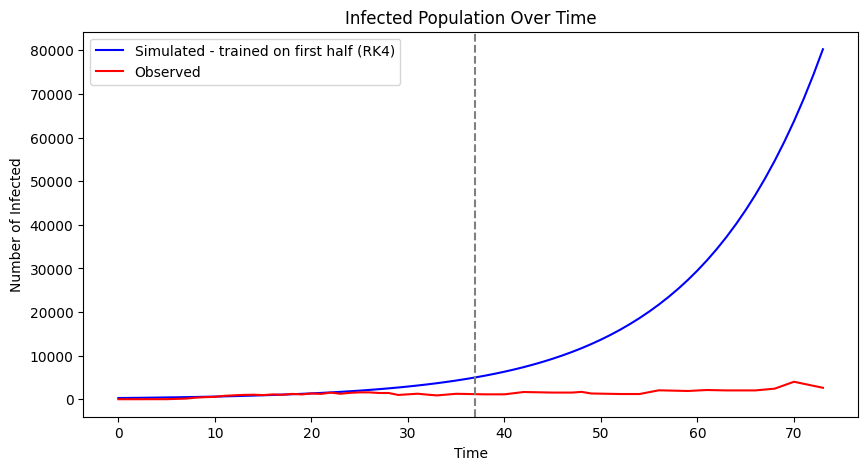

In [13]:
mid = len(SIR_df) // 2

I_obs_train = SIR_df_half['I_est'].astype(float)
t_obs_train = np.arange(0, len(I_obs_train))

sol_half = solve_ivp(fun,
                     t_span=[t_obs_train[0], t_obs_train[-1]], 
                     y0=[S0_obs, I0_obs, R0_obs],
                     args=(beta, gamma, N),
                     t_eval=t_obs_train,
                     method='RK45')

S_half, I_half, R_half = sol_half.y

sol_full = solve_ivp(fun,
                     t_span=[0, len(SIR_df)],
                     y0=[S_half[-1], I_half[-1], R_half[-1]],
                     args=(beta, gamma, N),
                     t_eval=np.arange(len(SIR_df)),
                     method='RK45')

S_full, I_full, R_full = sol_full.y

# Plot full comparison
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(SIR_df)), I_full, label='Simulated - trained on first half (RK4)', color='blue')
plt.plot(np.arange(len(SIR_df)), SIR_df['I_est'], label='Observed', color='red')
plt.axvline(x=mid, color='gray', linestyle='--')

plt.title('Infected Population Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Infected')
plt.legend()
plt.show()


Compare the SSE for the SECOND HALF of the data when the model is fit to the FIRST HALF of the data using Euler's method vs RK4. Did RK4 do a better job?  Why or why not?

This SSE is significantly larger, because using RK4, the model is overpredicting instead of underpredicting. Given Mexico's large population, this leads to a large predicted outbreak, which is not reflective of the observed outbreak conditions. 

In [14]:
# SSE comparison between Euler's method and RK4 (solve_ivp) on the SECOND HALF of the data.

I_pred = I_full[len(I)//2:]


sse_second_half_rk4 = np.sum((I_pred - I_obs)**2) 
print("SSE on the second half of the data (RK4):", sse_second_half_rk4)

print("This is " + str(sse_second_half_rk4 / sse_second_half_euler) + " times the SSE from Euler's method.")

SSE on the second half of the data (RK4): 40371010844.94241
This is 275.2203947284046 times the SSE from Euler's method.


#### 4. Improving model fit by overcoming model limitations

Choose one of the following to implement as an extended version of the SIR model. Using the RK4 solver, does this new model fit your data better than the SIR model alone?

<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Options to overcome limitations (choose ONE to implement):</b> 

<ol>
<li> Include births in the model as described in reading.</li> 
<li>Include deaths in the model as described in reading.</li>
<li>Include an exposed compartment (SEIR model). </li>
<li>Include loss of immunity (i.e. R population can go back to S population).</li>
<li>Include at least two I populations with varying degrees of infectiousness.</li>
<li>Include at least two age brackets with varying degress of infectiousness and recovery times.</li>

</ol>

Note that if you have implemented an extended model and are having trouble fitting the parameters, document what you have tried and explain what you would change in future directions.
</div>



# Extended model implementation, parameter fitting, and plotting.

* We decided to implement an SEIR model, adding the exposed (E) population. 
* Research shows that H1N1 has a median incubation period of about 2 days, so we will set the incubation rate sigma to 1/2. (https://www.ncbi.nlm.nih.gov/books/NBK513241/)

In [15]:
# Creating the function using euler approximation and a SEIR model
sigma = 1/2

def euler_seir(beta, gamma, sigma, S0, E0, I0, R0, t, N):
    """
    Solve the SIR model using Euler's method.
    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - S0: Initial susceptible population
    - E0: Initial exposed population
    - I0: Initial infected population
    - R0: Initial recovered population
    - t: Array of time points (days or weeks)
    - N: Total population
    Returns:
    - S: Array of susceptible population over time
    - E: Array of exposed population over time
    - I: Array of infected population over time
    - R: Array of recovered population over time
    """
    S = np.empty(len(t), float)
    E = np.empty(len(t), float)
    I = np.empty(len(t), float)
    R = np.empty(len(t), float)
    S[0], E[0], I[0], R[0] = S0, E0, I0, R0
    for n in range(len(t) - 1):
        dt = t[n + 1] - t[n]  # dt is our step size (1 day or 1 week)
        dS = -beta/N * I[n] * S[n]
        dE = beta/N * I[n] * S[n] - sigma * E[n]
        dI = sigma * E[n] - gamma * I[n]
        dR = gamma * I[n]
        S[n + 1] = S[n] + dS * dt
        E[n + 1] = E[n] + dE * dt
        I[n + 1] = I[n] + dI * dt
        R[n + 1] = R[n] + dR * dt
    return S, E, I, R


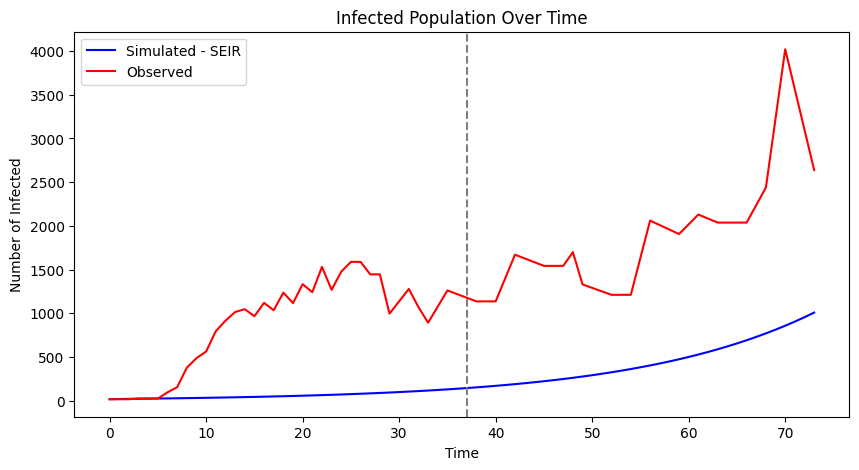

In [16]:
S_seir, E_seir, I_seir, R_seir = euler_seir(beta, gamma, sigma, S0=S0_obs, E0=10, I0=I0_obs, R0=R0_obs, t=t_obs, N=N)

# Plot full comparison
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(SIR_df)), I_seir, label='Simulated - SEIR', color='blue')
plt.plot(np.arange(len(SIR_df)), SIR_df['I_est'], label='Observed', color='red')
plt.axvline(x=mid, color='gray', linestyle='--')

plt.title('Infected Population Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Infected')
plt.legend()
plt.show()

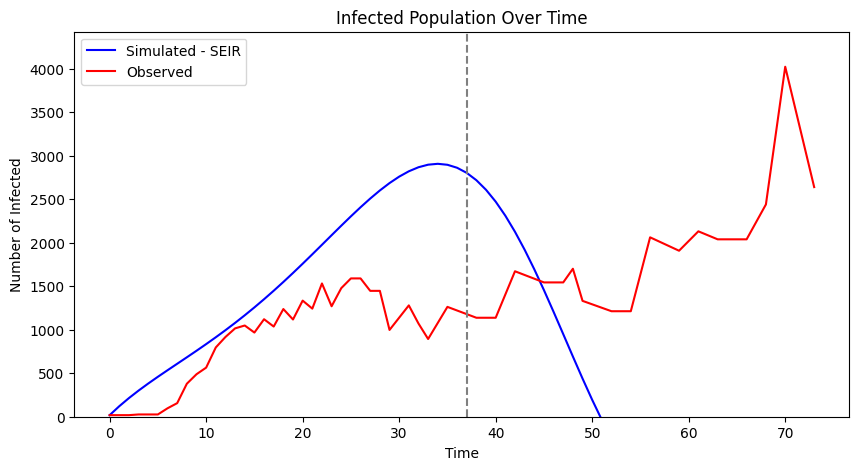

In [17]:
# Optimizing parameters using scipy using the first half of the dataset

def sse_seir(params):
    beta, gamma, sigma = params
    S, E, I, R = euler_seir(beta, gamma, sigma, S0_obs, 10, I0_obs, R0_obs, t_obs, N)
    I_first_half = I[:len(I)//2]
    return np.sum((I_first_half - I_obs)**2)

result_seir = minimize(sse_seir, x0=[beta, gamma, sigma], method="Nelder-Mead")
beta_seir_opt, gamma_seir_opt, sigma_seir_opt = result_seir.x

# Plot with the optimized beta, gamma, and sigma values.
S_seir_opt, E_seir_opt, I_seir_opt, R_seir_opt = euler_seir(beta_seir_opt, gamma_seir_opt, sigma_seir_opt, S0_obs, 10, I0_obs, R0_obs, t_obs, N)

# Plot full comparison
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(SIR_df)), I_seir_opt, label='Simulated - SEIR', color='blue')
plt.plot(np.arange(len(SIR_df)), SIR_df['I_est'], label='Observed', color='red')
plt.axvline(x=mid, color='gray', linestyle='--')
plt.ylim(0, max(SIR_df['I_est']) * 1.1) 

plt.title('Infected Population Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Infected')
plt.legend()
plt.show()


In [20]:
# Calculating SSE on the second half of the data for SEIR model
I_pred_seir = I_seir_opt[len(I_seir_opt)//2:]

# Ensuring no values of infected are negative
for i in I_pred_seir:
    if i < 0:
        i = 0
sse_second_half_seir = np.sum(I_pred_seir - I_obs)**2

print("SSE on the second half of the data (SEIR):", sse_second_half_seir)

# How this compares to Euler and RK4
print("This is " + str(sse_second_half_seir / sse_second_half_euler) + " times the SSE from Euler's method.")
print("This is " + str(sse_second_half_seir / sse_second_half_rk4) + " times the SSE from RK4 method.")

SSE on the second half of the data (SEIR): 3782540248.971209
This is 25.786627548077657 times the SSE from Euler's method.
This is 0.09369446466176551 times the SSE from RK4 method.


# Evaluation of the SEIR model

The new SEIR model, trained on the first half of data, appears to be our best model prediction yet. Although it predicts that the infection will die out in 50 days, the predicted peak is similar to the real data. Considering our data is partly interpolated, noisy, and only spans 70 days, it would be difficult to get a great fit, but the SEIR model seems to be more realistic. The SSE for the second half of the data for this model was 3,782,540,248.

The SSE (calculated on the second half of the data) shows that this method is a lot better than the RK4 estimate, with approximately 1/10th of its error. However, it's worse than our manually tuned Euler's model. Nevertheless, when the data is extrapolated beyond 70 days, we believe the SEIR model is more accurate, as the manually-fit euler's method would predict a very large increase in cases before the virus dies down.

## Verify and validate your analysis: 

We verified our analysis by creating and using several different optimization methods. For one method we hard coded and optimization function, but this was largely unsuccessful and did not create a great prediction. We then used the built in optimization function from SciPy and this created a better prediction result. Similarly, we used Euler's method alongside an RK4 method and generated two separate sums of squared errors. For the prediction using Euler's method on the second half of the data, the SSE was 146,686,116 and for the prediction using RK4 on the second half of the data the SSE was 40,371,010,844. This indicates that our prediction got worse and this also passes the eye test when looking at our data. Overall, our model was creating predictions in the correct ways, however, these predictions were quite inaccurate. Our last model was an SEIR prediction which created the best prediction overall. Although it predicted the epidemic to end in 50 days, due to the limitations of our data set this appeared to be a resonable estimation to the epidemic. However, this model had a SSE for the second half of the data of 3,782,540,248 which indiactes that it was better than the RK4 method but worse than the Euler's method. This is slightly misleading due to it predicting the epidemic was ending after 50 days, and with some tweaking we believe this could be better than the Euler's method. To validate our methods, we found a paper titled "A model for the A(H1N1) epidemic in Mexico, including social isolation" used similar ODEs to our model and had an R0 of 1.58. Our R0  was 1.00 which is quite different from what the paper predicted. This paper validates our conclusion that our model was inaccurate and should not be used as a predictor for this epidemic.

Paper: Velasco-Hernández JX, Leite MC. A model for the A(H1N1) epidemic in Mexico, including social isolation. Salud Publica Mex. 2011 Jan-Feb;53(1):40-7. doi: 10.1590/s0036-36342011000100007. PMID: 21340139.

## Conclusions and Ethical Implications: 
Our analysis generated an overall inaccurate prediction of the epidemiological path of the H1N1 virus in Mexico during 2009. This has many significant ethical implications including influencing governmental policies, prediction of the outcome of the epidemic, and predictions of future epidemics. Our model should not be utilized as evidence to determine government policies and influence organizations on shutdown, reopen, and other safety policies. This is because our model has done poorly in predicting future infection values and often is not better than a guess. Similarly, these models must be understood as predictions when communicating with the public. Due to epidemics and pandemics causing anxiety for many, these models should be communicated clearly when reporting to individuals about the potential duration of epidemics and pandemics. Likewise, our model showed the limitations of a SIR model when provided with poor real world data and few parameters to validate the model off of. By simply using a SEIR model instead of a SIR model our prediction got much better. The SEIR model was relatively close to predicting the maximum number of infected at one time (3,000 predicted infections compared to 4,000 real infections) and the only limitation of the model was failing to predict the second rise in cases. This emphasizes the complexities of epidemics and how this complexity has to be relfected in the prediction models.

## Limitations and Future Work: 
One limitation in our model was the data set we were provided. This data set was missing many values and often had repeating values for several days in a row. This questions the initial reliability of the data and if we should have looked for a better data set to develop our model on. Similarly, adding extra parameters into our ODEs could make a better model. Adding parameters to split transmission rate into two categories: one being transmission from infected individuals to non-isolated susceptible individuals and transmission from infected individuals to isolated susceptible individuals. Another useful parameter could be rate of early detection and a rate based on governmental policy such as rate at which individuals suspend sanitary measures. Overall, the complexity of illness and the transmission factors that determine an epidemic has to be relfected in the model and without adding these parameters, researchers cannot expect their model to have strong predicting power that will be helpful to the overall population.

## NOTES FROM YOUR TEAM: 


## QUESTIONS FOR YOUR TA: 
Thanks for a great semester!